# Predict stock price using LSTM

In this notebook I use a Long Short-Term Memory model to predict the trend of a stock. Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN). LSTM models have the ability to store the ouput from a node to memory, and use it as future input. The ability to 'remember' past data makes it well suited for time-series prediction, and it should be preferred over feed-forward only models. 
It is important to note that I do not try to predict the actual stock price but rather use the model to get an indication of the stock price momentum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import datetime as dt
from matplotlib import style
import pandas_datareader.data as web

First read in the stocks historic price data. For the purposes of this notebook I shall limit the data to about 10 years of data.

In [2]:
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime.now()

stock = "GOOG"
df = web.DataReader(stock, 'yahoo', start_date, end_date)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927000.0,312.204773
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031900.0,310.829926
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987100.0,302.994293
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876600.0,295.940735
2010-01-08,300.498657,293.455048,294.894653,299.885956,9483900.0,299.885956


The Adjusted Close will be our target label. Display the historic adjusted close price to visualise the trend.

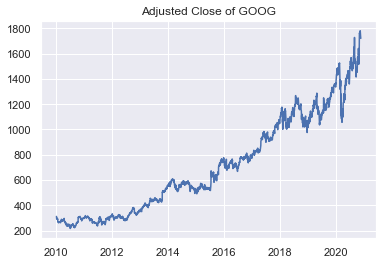

In [3]:
import seaborn as sns
style.use('ggplot')

sns.set()
plt.title('Adjusted Close of {:s}' .format(stock))
plt.plot(df['Adj Close'])
plt.show()

In [4]:
# split time series into train and test sets
n_intervals = len(df)
n_train = int(0.8 * n_intervals)   

df_training = df.iloc[:n_train]
df_training = df_training['Adj Close'].values
df_training = df_training.reshape(-1, 1)

df_test = df.iloc[n_train:]
df_test = df_test['Adj Close'].values
df_test = df_test.reshape(-1, 1)


In [5]:
# rescale the data
scaler = MinMaxScaler()

df_training = scaler.fit_transform(df_training)


In [6]:
# for the features of the LSTM I use the previous 60 day adjusted close prices
X_train = []
y_train = []

for i in range(60, df_training.shape[0]):
    X_train.append(df_training[i-60:i])
    y_train.append(df_training[i, 0])


X_train, y_train = np.array(X_train), np.array(y_train)

# Build LSTM
Build and fit the LSTM model.


In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [8]:
regressor = Sequential()

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 240, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [9]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(X_train,y_train,validation_split=0.2,epochs=10,batch_size=120)

Train on 1707 samples, validate on 427 samples
Epoch 1/10
1707/1707 [==============================] - 6s 4ms/sample - loss: 0.0324 - val_loss: 0.1302
Epoch 2/10
1707/1707 [==============================] - 3s 2ms/sample - loss: 0.0052 - val_loss: 0.0023
Epoch 3/10
1707/1707 [==============================] - 4s 2ms/sample - loss: 0.0021 - val_loss: 0.0043
Epoch 4/10
1707/1707 [==============================] - 4s 2ms/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
1707/1707 [==============================] - 5s 3ms/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 6/10
1707/1707 [==============================] - 5s 3ms/sample - loss: 0.0016 - val_loss: 0.0018
Epoch 7/10
1707/1707 [==============================] - 5s 3ms/sample - loss: 0.0016 - val_loss: 0.0015
Epoch 8/10
1707/1707 [==============================] - 5s 3ms/sample - loss: 0.0013 - val_loss: 0.0018
Epoch 9/10
1707/1707 [==============================] - 5s 3ms/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 10/10
1707/

In the last epochs both the training loss and the validation loss are very low, so we can have some confidence that the model is a good estimator for stock price trend.
I plot the training loss against the validation loss below. We can observe that both the training and validation loss are quickly reduced and converge towards 0. The training and validation loss remain close, indicating that the model is not over-fitted or under-fitted. 

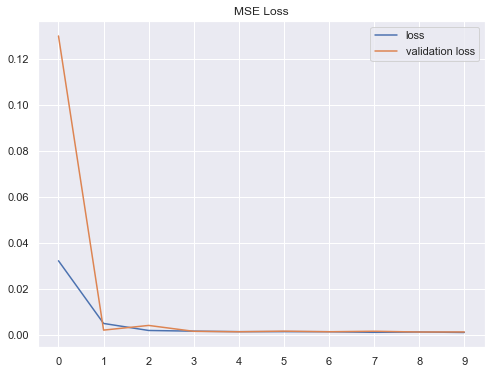

In [10]:
plt.figure(figsize=(8,6))
plt.title('MSE Loss')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.xticks(history.epoch)
plt.legend()
plt.show()


# Evaluate

In this step I use the test data, which I had split off from the training data, to evaluate the model.

In [11]:
# I perform the same process used on the training data, to scale the test data 
# and build a factor matrix of the previous 60 days of adjusted closing prices 
df_test = scaler.fit_transform(df_test)

X_test = []
y_test = []

for i in range(60, df_test.shape[0]):
    X_test.append(df_test[i-60:i])
    y_test.append(df_test[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

# predict y from test features
y_hat = regressor.predict(X_test)

# We will multiply y_pred and y_test with the inverse of scale to get all the values to the original scale.
scale = 1/scaler.scale_[0]

#y_test = np.array(y_test)
y_test = y_test*scale
y_hat = y_hat*scale

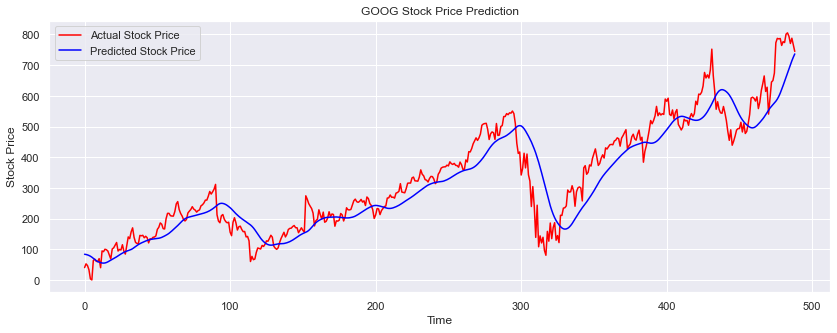

In [12]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Actual Stock Price' )
plt.plot(y_hat, color = 'blue', label = 'Predicted Stock Price' )
plt.title('{:s} Stock Price Prediction' .format(stock))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
